In [1]:
import pandas as pd
import numpy as np
import warnings
import pickle
import seaborn as sns

from fancyimpute import *
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

Using TensorFlow backend.


Devo risolvere il problema secondo questo use case: oggi mi arrivano i dati di ieri, cosa mi dicono i dati di ieri? Sono anticipatori di una possibile giornata pesante?

# 1.0 Data retrival

In [2]:
df = pd.read_pickle('../output/df_understanding.pkl')

Are there any edits necessary? 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12110 entries, 1988-05-05 to 2021-06-30
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Precipitazione dalle 9 alle 9 ( mm )  11878 non-null  object 
 1   Precipitazione dalle 0 alle 0 ( mm )  12023 non-null  object 
 2   Temperatura media ( °C )              12084 non-null  object 
 3   Temperatura massima ( °C )            11893 non-null  object 
 4   Temperatura minima ( °C )             11884 non-null  object 
 5   Umidita' media ( % )                  11489 non-null  float64
 6   Umidita' massima ( % )                11291 non-null  float64
 7   Umidita' minima ( % )                 11291 non-null  float64
 8   Velocita' media ( m/s )               11067 non-null  object 
 9   Raffica ( m/s )                       10860 non-null  object 
 10  Durata Calma ( min )                  11067 non-null  float64
 11

It's necessary to change the data types of numerical columns into float!

In [4]:
for i in df:
    if df[i].dtypes == 'object':
        if i == 'Settore Prevalente':
            pass
        else:
            print(i)
            df[i] = df[i].str.replace(',', '.').astype(float)

Precipitazione dalle 9 alle 9 ( mm )
Precipitazione dalle 0 alle 0 ( mm )
Temperatura media ( °C )
Temperatura massima ( °C )
Temperatura minima ( °C )
Velocita' media ( m/s )
Raffica ( m/s )
Radiazione totale ( MJ/mq )


In [5]:
df.dtypes

Precipitazione dalle 9 alle 9 ( mm )    float64
Precipitazione dalle 0 alle 0 ( mm )    float64
Temperatura media ( °C )                float64
Temperatura massima ( °C )              float64
Temperatura minima ( °C )               float64
Umidita' media ( % )                    float64
Umidita' massima ( % )                  float64
Umidita' minima ( % )                   float64
Velocita' media ( m/s )                 float64
Raffica ( m/s )                         float64
Durata Calma ( min )                    float64
Settore Prevalente                       object
Tempo Permanenza ( min )                float64
Radiazione totale ( MJ/mq )             float64
dtype: object

# Data exploration

Let's have a look at the only categorical variable in the dataset.

In [6]:
df['Settore Prevalente'].value_counts()

N                 3691
SSW               1482
NNE               1432
S                  317
SW                  91
NNW                 54
NE                  46
SSE                 39
SE                   3
Calma di vento       2
Name: Settore Prevalente, dtype: int64

Let's to a numerical encoding.

In [9]:
df['Settore Prevalente'] = df['Settore Prevalente'].astype(str)

df['Settore Prevalente'] = le.fit_transform(df['Settore Prevalente'])

df['Settore Prevalente'].value_counts()

La classe "10" corrisponde ai NaN: la riporto come tale

In [11]:
df['Settore Prevalente'] = df['Settore Prevalente'].mask(df['Settore Prevalente']==10,np.nan)

df['Settore Prevalente'].value_counts()

Let's have a look at the pairwise relationship in the data.

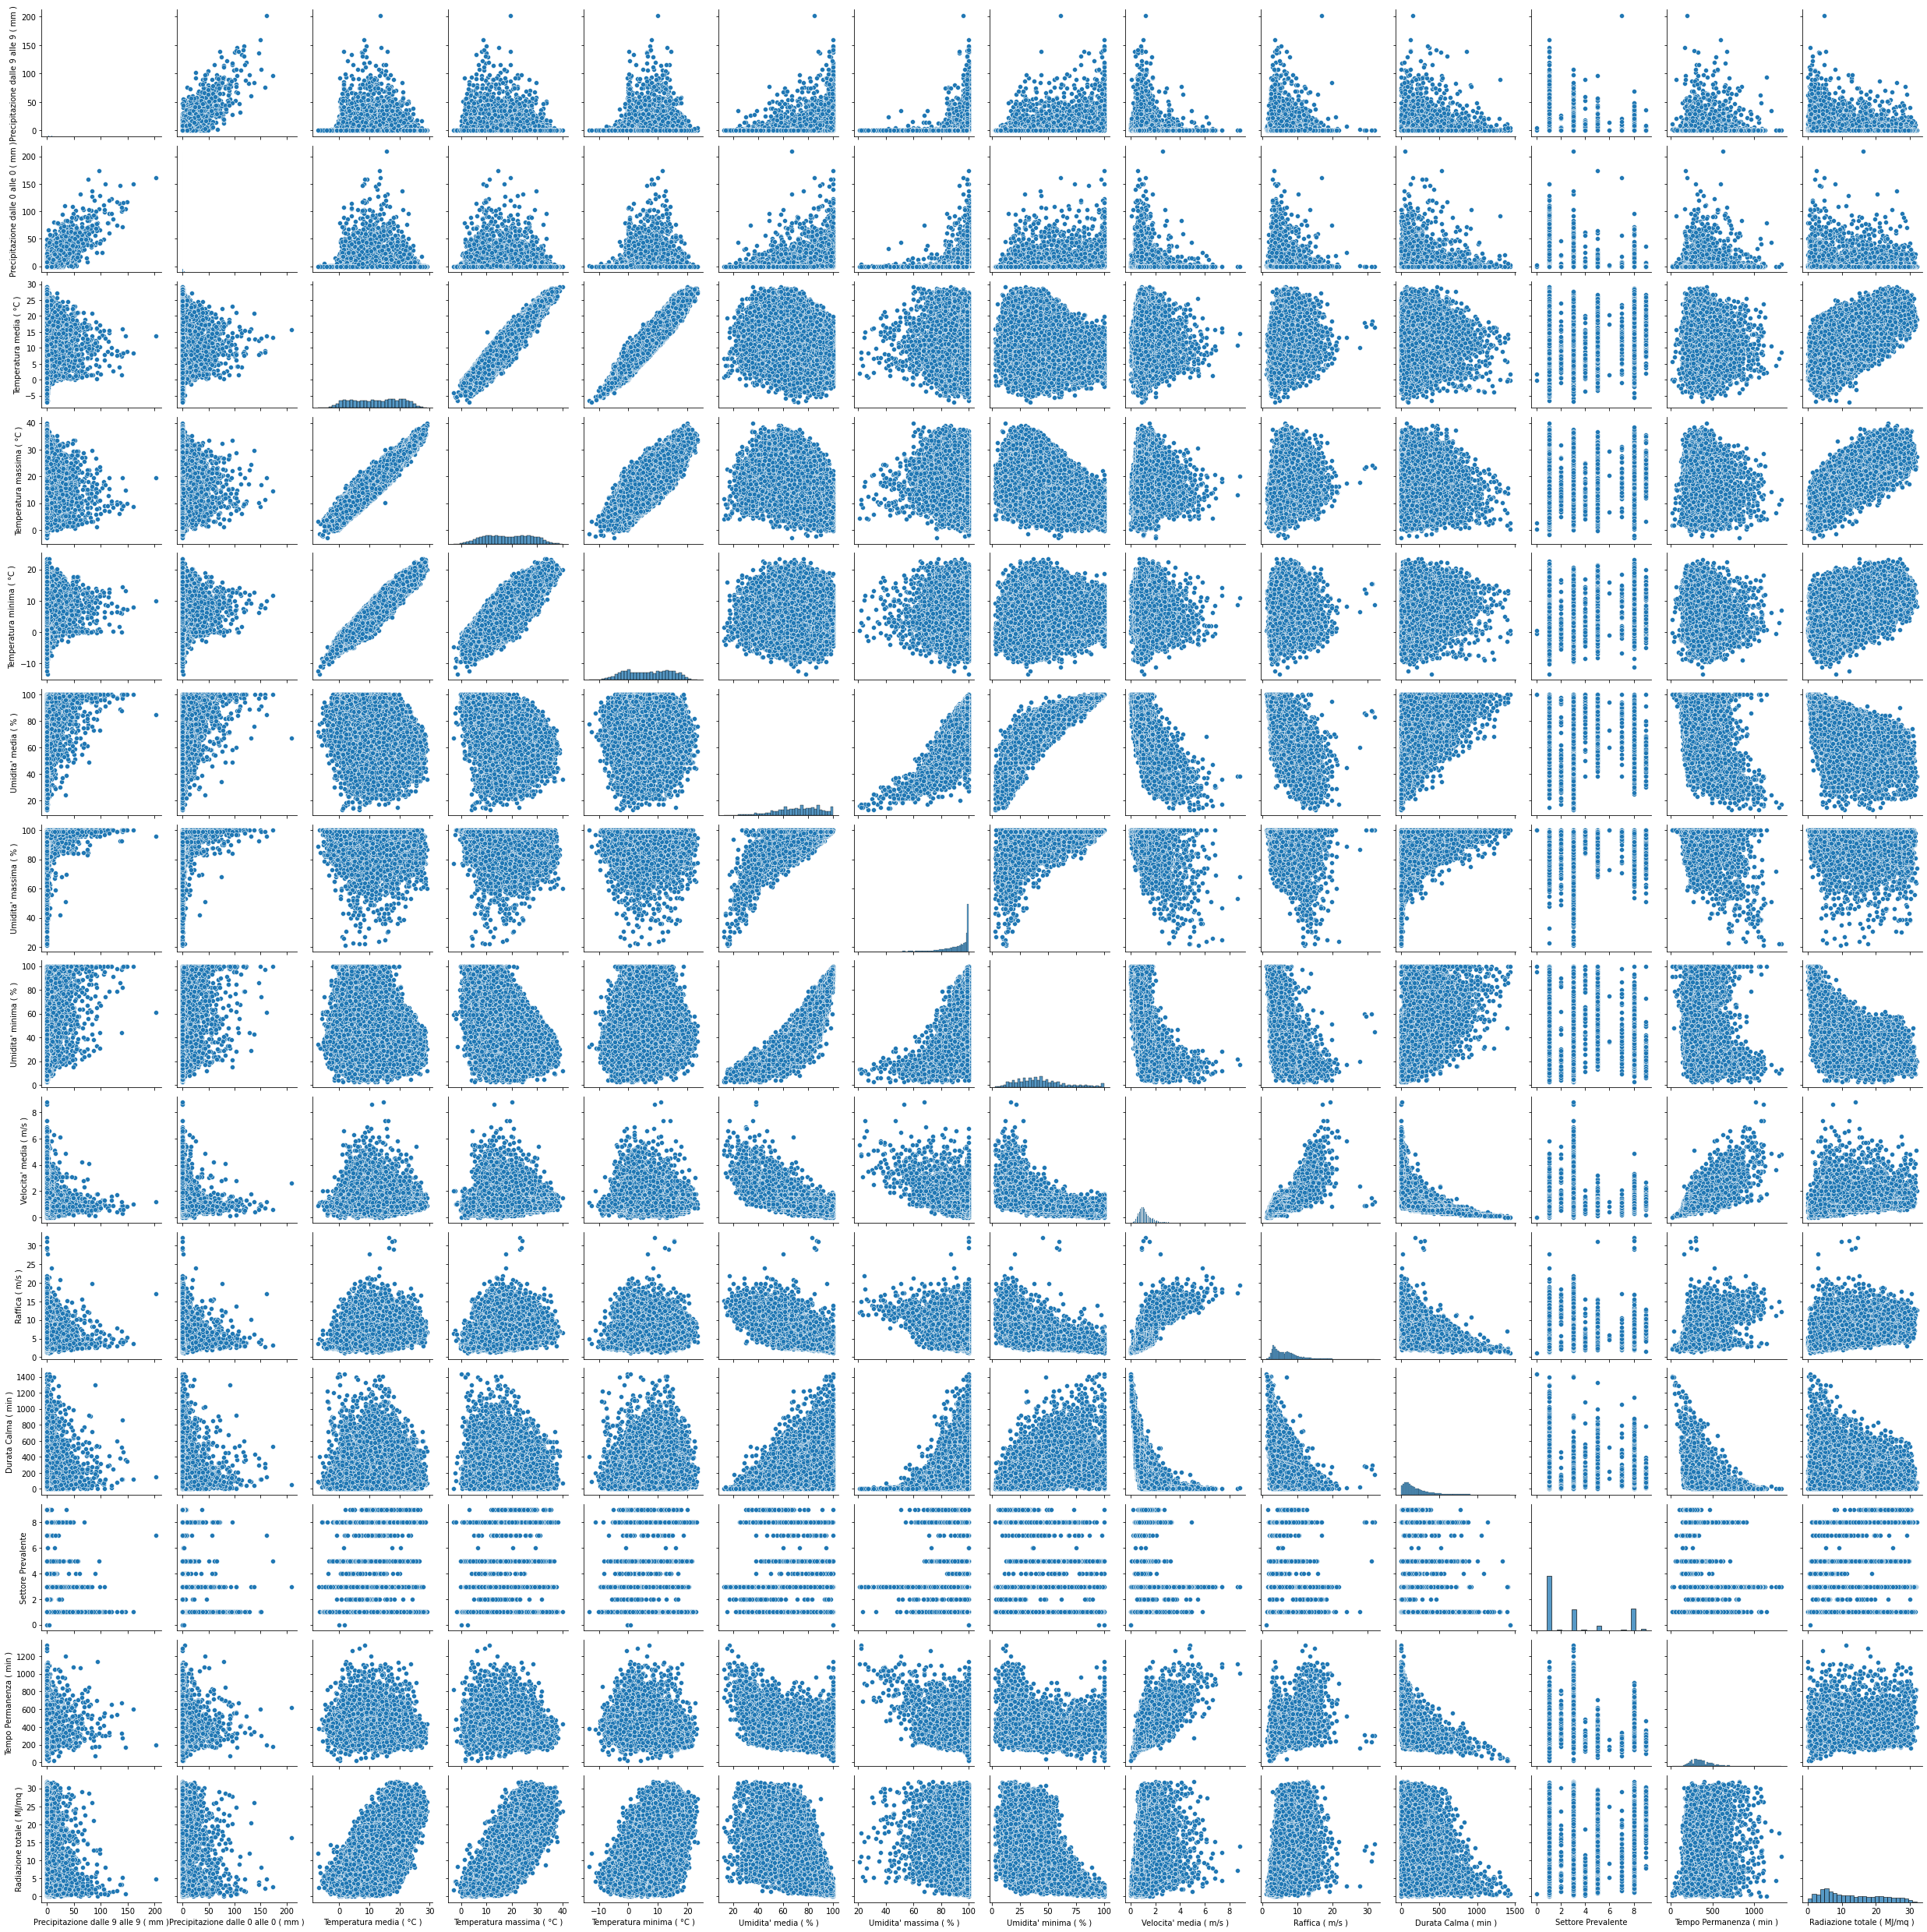

In [12]:
sns.pairplot(df)

As expected, there are some relationship between variables! Are there any missing values?

In [13]:
df.isna().sum()

Precipitazione dalle 9 alle 9 ( mm )     232
Precipitazione dalle 0 alle 0 ( mm )      87
Temperatura media ( °C )                  26
Temperatura massima ( °C )               217
Temperatura minima ( °C )                226
Umidita' media ( % )                     621
Umidita' massima ( % )                   819
Umidita' minima ( % )                    819
Velocita' media ( m/s )                 1043
Raffica ( m/s )                         1250
Durata Calma ( min )                    1043
Settore Prevalente                      4953
Tempo Permanenza ( min )                4955
Radiazione totale ( MJ/mq )              872
dtype: int64

How to fill them? These in my opinion are the options available:
- expectation maximization from different distribution to contemplate different variables (continuos, categorical)
- MICE
- KNN

For a first try, let's use a simple KNN to fill missing values: it's the fastest (and quit smart) solution!

In [14]:
df.head(3)

Precipitazione dalle 9 alle 9 ( mm )  \
Data                                               
1988-05-05                                   3.8   
1988-05-06                                   0.0   
1988-05-07                                   0.0   

            Precipitazione dalle 0 alle 0 ( mm )  Temperatura media ( °C )  \
Data                                                                         
1988-05-05                                   3.6                      14.7   
1988-05-06                                   0.2                      17.5   
1988-05-07                                   0.0                      19.1   

            Temperatura massima ( °C )  Temperatura minima ( °C )  \
Data                                                                
1988-05-05                        22.6                        9.6   
1988-05-06                        27.0                        8.1   
1988-05-07                        26.2                       12.9   

            Umidita' media ( % )  Umidita' massima ( % )  \
Data                                                       
1988-05-05                   NaN                     NaN   
1988-05-06                   NaN                     NaN   
1988-05-07                   NaN                     NaN   

            Umidita' minima ( % )  Velocita' media ( m/s )  Raffica ( m/s )  \
Data                                                                          
1988-05-05                    NaN                      NaN              NaN   
1988-05-06                    NaN                      NaN              NaN   
1988-05-07                    NaN                      NaN              NaN   

            Durata Calma ( min )  Settore Prevalente  \
Data                                                   
1988-05-05                   NaN                 NaN   
1988-05-06                   NaN                 NaN   
1988-05-07                   NaN                 NaN   

            Tempo Permanenza ( min )  Radiazione totale ( MJ/mq )  
Data                                                               
1988-05-05                       NaN                          NaN  
1988-05-06                       NaN                          NaN  
1988-05-07                       NaN                          NaN

In [15]:
knn_imputer = KNN(k=10,verbose=False)

In [16]:
imp_knn = knn_imputer.fit_transform(df) 
df_knn = pd.DataFrame(imp_knn,columns=df.columns)

In [17]:
df_knn.head(3)

Precipitazione dalle 9 alle 9 ( mm )  Precipitazione dalle 0 alle 0 ( mm )  \
0                                   3.8                                   3.6   
1                                   0.0                                   0.2   
2                                   0.0                                   0.0   

   Temperatura media ( °C )  Temperatura massima ( °C )  \
0                      14.7                        22.6   
1                      17.5                        27.0   
2                      19.1                        26.2   

   Temperatura minima ( °C )  Umidita' media ( % )  Umidita' massima ( % )  \
0                        9.6             70.433480               97.291174   
1                        8.1             54.394726               79.483470   
2                       12.9             48.011480               92.688593   

   Umidita' minima ( % )  Velocita' media ( m/s )  Raffica ( m/s )  \
0              34.658084                 1.366919         8.493583   
1              19.902824                 1.387578         7.981243   
2              44.394152                 1.799717         7.343288   

   Durata Calma ( min )  Settore Prevalente  Tempo Permanenza ( min )  \
0            167.706199            3.383951                435.422915   
1            192.603491            5.175788                363.094092   
2            100.070276            3.000130                330.009159   

   Radiazione totale ( MJ/mq )  
0                    16.751609  
1                    18.887784  
2                    21.298000

In [18]:
df = pd.concat([pd.DataFrame(df.index),df_knn],axis=1)

In [19]:
df['Settore Prevalente'] = df['Settore Prevalente'].round(0)

In [20]:
df.head(3)

Data  Precipitazione dalle 9 alle 9 ( mm )  \
0 1988-05-05                                   3.8   
1 1988-05-06                                   0.0   
2 1988-05-07                                   0.0   

   Precipitazione dalle 0 alle 0 ( mm )  Temperatura media ( °C )  \
0                                   3.6                      14.7   
1                                   0.2                      17.5   
2                                   0.0                      19.1   

   Temperatura massima ( °C )  Temperatura minima ( °C )  \
0                        22.6                        9.6   
1                        27.0                        8.1   
2                        26.2                       12.9   

   Umidita' media ( % )  Umidita' massima ( % )  Umidita' minima ( % )  \
0             70.433480               97.291174              34.658084   
1             54.394726               79.483470              19.902824   
2             48.011480               92.688593              44.394152   

   Velocita' media ( m/s )  Raffica ( m/s )  Durata Calma ( min )  \
0                 1.366919         8.493583            167.706199   
1                 1.387578         7.981243            192.603491   
2                 1.799717         7.343288            100.070276   

   Settore Prevalente  Tempo Permanenza ( min )  Radiazione totale ( MJ/mq )  
0                 3.0                435.422915                    16.751609  
1                 5.0                363.094092                    18.887784  
2                 3.0                330.009159                    21.298000

In [21]:
df.isna().sum()

Data                                    0
Precipitazione dalle 9 alle 9 ( mm )    0
Precipitazione dalle 0 alle 0 ( mm )    0
Temperatura media ( °C )                0
Temperatura massima ( °C )              0
Temperatura minima ( °C )               0
Umidita' media ( % )                    0
Umidita' massima ( % )                  0
Umidita' minima ( % )                   0
Velocita' media ( m/s )                 0
Raffica ( m/s )                         0
Durata Calma ( min )                    0
Settore Prevalente                      0
Tempo Permanenza ( min )                0
Radiazione totale ( MJ/mq )             0
dtype: int64

# Label creation

In [29]:
df['precipitazione_media'] = df[['Precipitazione dalle 9 alle 9 ( mm )','Precipitazione dalle 0 alle 0 ( mm )']].mean(axis=1)
df = df.drop(columns=['Precipitazione dalle 0 alle 0 ( mm )','Precipitazione dalle 9 alle 9 ( mm )'])

df['evento_estremo'] = 0
df['evento_estremo'] = df['evento_estremo'].mask(df['precipitazione_media']>=50,1)

df['anticipatore'] = 0

df['anticipatore'] = df['anticipatore'].mask(df['evento_estremo']==1,1).shift(-1)

df[df['Data']=='2020-10-02']

df['anticipatore'].value_counts(normalize=True)*100

# Output

In [30]:
df.to_pickle('../output/df_prep.pkl')